### Gravar áudio e analisar

Gravando por 5 segundos...
Gravação finalizada.
Áudio salvo como gravacao.wav.


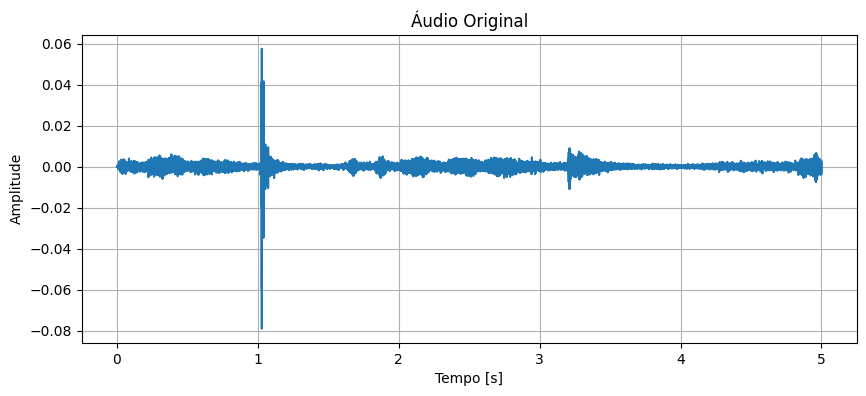

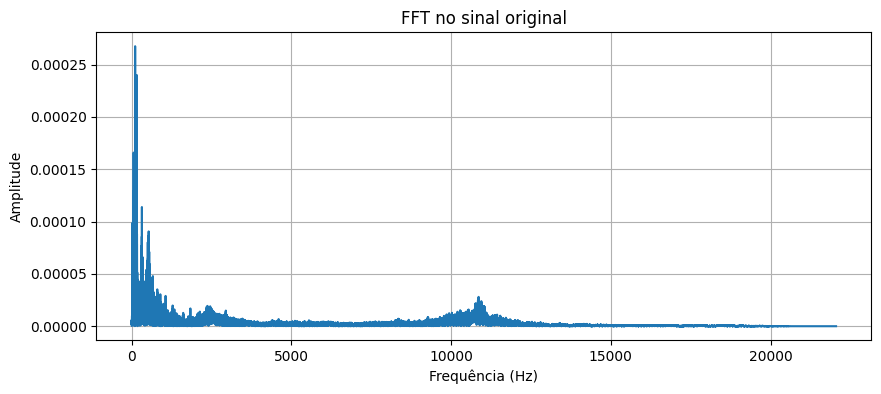

In [26]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

# Função para gravar o som
def record_sound(duration, sample_rate):
    print(f"Gravando por {duration} segundos...")
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float64')
    sd.wait()  # Espera a gravação terminar
    print("Gravação finalizada.")
    return audio_data

# Função para salvar o som em um arquivo WAV
def save_audio(audio_data, sample_rate, filename):
    audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)  # Converte para int16
    wav.write(filename, sample_rate, audio_data)
    print(f"Áudio salvo como {filename}.")

# Função para plotar o áudio no domínio do tempo
def plot_time_domain(audio_data, sample_rate):
    N = len(audio_data)
    time = np.linspace(0., N / sample_rate, N)
    
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio_data)
    plt.title("Áudio Original")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

# Função para aplicar a FFT
def apply_fft(audio_data, sample_rate):
    # Aplicar FFT
    N = len(audio_data)
    T = 1.0 / sample_rate
    yf = np.fft.fft(audio_data[:, 0])
    xf = np.fft.fftfreq(N, T)[:N // 2] # não sei o que isso faz kkkkkk

    # Gráfico da FFT
    plt.figure(figsize=(10, 4))
    plt.plot(xf, 2.0 / N * np.abs(yf[:N // 2]))
    plt.grid()
    plt.title("FFT no sinal original")
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

# Configurações
DURATION = 2  # Duração da gravação em segundos
SAMPLE_RATE = 44100  # Taxa de amostragem (44100 Hz é o padrão de CD)
FILENAME = "gravacao.wav"  # Nome do arquivo de saída

# Gravar áudio
audio = record_sound(DURATION, SAMPLE_RATE)

# Salvar áudio em um arquivo
save_audio(audio, SAMPLE_RATE, FILENAME)

# Mostrar gráfico no domínio do tempo
plot_time_domain(audio, SAMPLE_RATE)

# Aplicar FFT no áudio gravado
apply_fft(audio, SAMPLE_RATE)

### Analisar audio já gravado

Áudio carregado de ./filtrado/audio_isolado.wav.


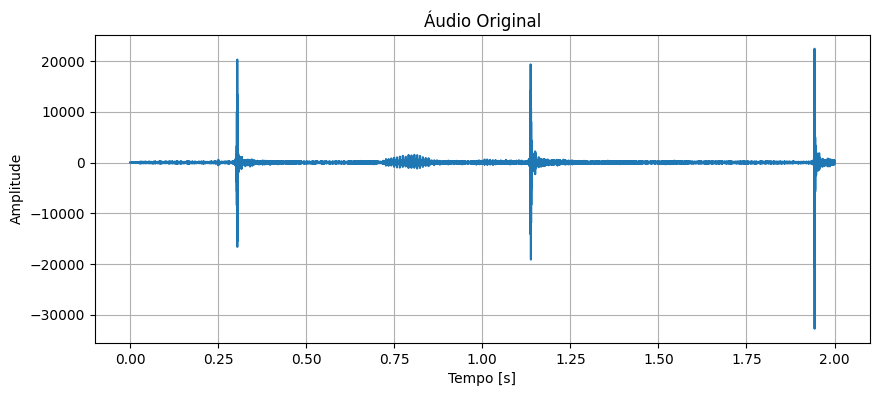

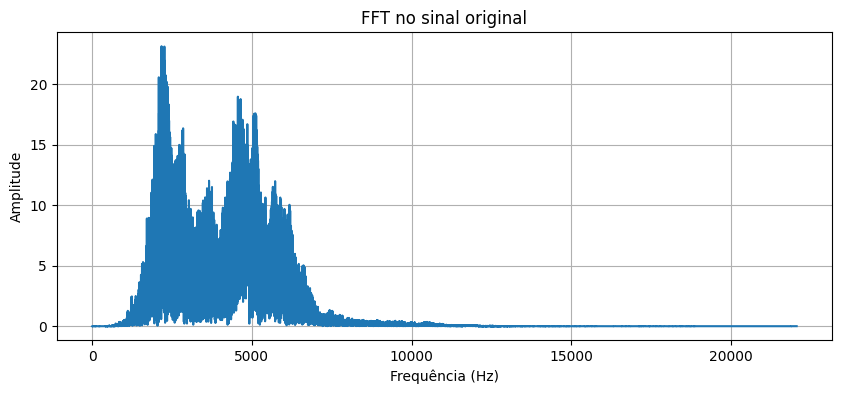

In [22]:
import scipy.io.wavfile as wav

# Função para carregar o áudio de um arquivo WAV
def load_audio(filename):
    sample_rate, audio_data = wav.read(filename)
    print(f"Áudio carregado de {filename}.")
    return sample_rate, audio_data

# Função para abrir o áudio e aplicar as mesmas análises
def process_audio_file(filename):
    # Carregar o áudio
    sample_rate, audio_data = load_audio(filename)
    
    # Se o áudio for estéreo, converte para mono
    if len(audio_data.shape) > 1:
        audio_data = np.mean(audio_data, axis=1)
    
    # Mostrar gráfico no domínio do tempo
    plot_time_domain(audio_data, sample_rate)
    
    # Aplicar FFT no áudio carregado
    apply_fft(audio_data.reshape(-1, 1), sample_rate)

# Exemplo de uso
FILENAME = "./filtrado/audio_isolado.wav"
process_audio_file(FILENAME)

### Aplicação do filtro

Áudio carregado de muito_ruido.wav.


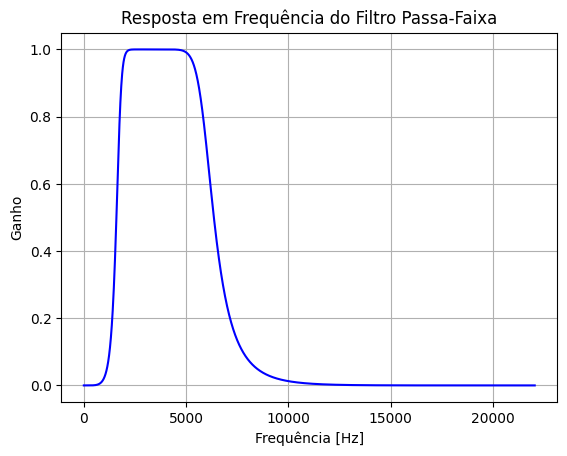

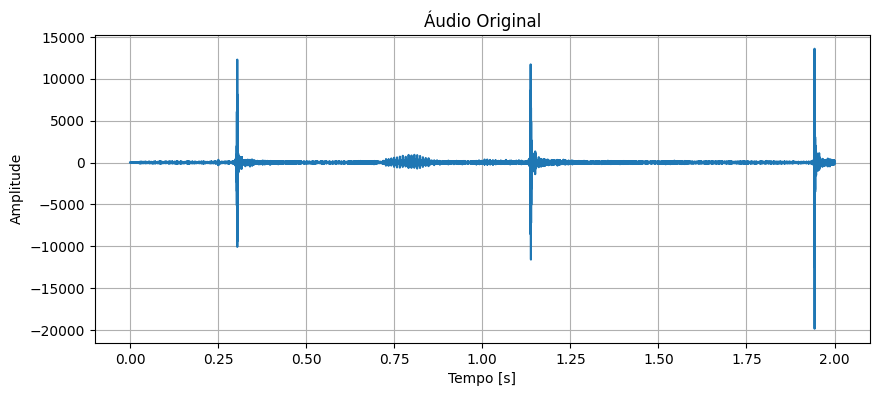

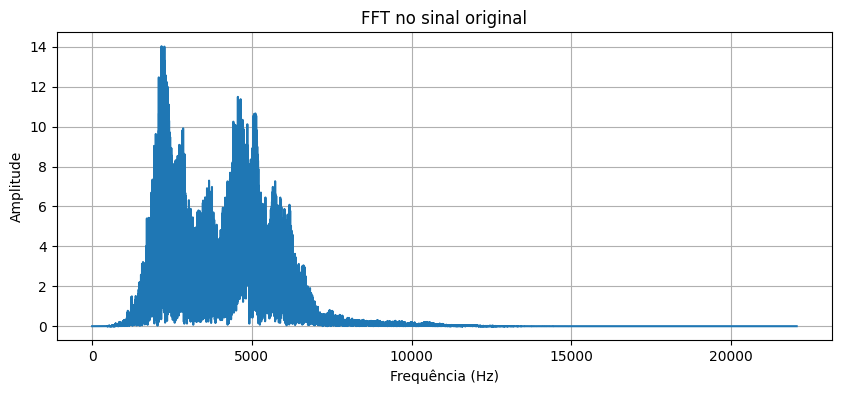

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

# Função para projetar um filtro passa-faixa Butterworth
def butter_bandpass(lowcut, highcut, sample_rate, order=5):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Função para aplicar o filtro no sinal
def apply_bandpass_filter(audio_data, sample_rate, lowcut, highcut, order=5):
    b, a = butter_bandpass(lowcut, highcut, sample_rate, order=order)
    y = lfilter(b, a, audio_data)
    return y

# Função para visualizar o filtro no domínio da frequência
def plot_filter_response(lowcut, highcut, sample_rate, order=5):
    b, a = butter_bandpass(lowcut, highcut, sample_rate, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((sample_rate * 0.5 / np.pi) * w, abs(h), 'b')
    plt.title("Resposta em Frequência do Filtro Passa-Faixa")
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Ganho')
    plt.grid()
    plt.show()

# Função principal para filtrar o áudio
def process_audio_with_bandpass(audio_data, sample_rate):
    # Defina as frequências de corte com base na FFT do estalo
    lowcut = 1700.0  # Frequência de corte inferior (exemplo)
    highcut = 6000.0  # Frequência de corte superior (exemplo)
    
    # Exibir a resposta do filtro
    plot_filter_response(lowcut, highcut, sample_rate)
    
    # Aplicar o filtro passa-faixa
    filtered_audio = apply_bandpass_filter(audio_data, sample_rate, lowcut, highcut)
    
    # Plotar o sinal filtrado no domínio do tempo
    plot_time_domain(filtered_audio, sample_rate)
    
    # Aplicar FFT ao sinal filtrado
    apply_fft(filtered_audio.reshape(-1, 1), sample_rate)

# Exemplo de uso
FILENAME = "muito_ruido.wav"
sample_rate, audio_data = load_audio(FILENAME)

# Se o áudio for estéreo, converte para mono
if len(audio_data.shape) > 1:
    audio_data = np.mean(audio_data, axis=1)

# Processar o áudio com o filtro passa-faixa
process_audio_with_bandpass(audio_data, sample_rate)

### Aplicando o filtro e gerando novo audio

In [14]:
import scipy.io.wavfile as wav

# Função para salvar o áudio filtrado
def save_filtered_audio(audio_data, sample_rate, filename):
    audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)  # Normalizar e converter para int16
    wav.write(filename, sample_rate, audio_data)
    print(f"Áudio filtrado salvo como {filename}.")

# Função principal para aplicar o filtro passa-faixa e salvar o áudio filtrado
def apply_bandpass_and_save(filename, output_filename, lowcut, highcut, order=5):
    # Carregar o áudio
    sample_rate, audio_data = load_audio(filename)
    
    # Se o áudio for estéreo, converte para mono
    if len(audio_data.shape) > 1:
        audio_data = np.mean(audio_data, axis=1)
    
    # Aplicar o filtro passa-faixa
    filtered_audio = apply_bandpass_filter(audio_data, sample_rate, lowcut, highcut, order)
    
    # Salvar o áudio filtrado em um novo arquivo
    save_filtered_audio(filtered_audio, sample_rate, output_filename)

# Exemplo de uso
FILENAME = "muito_ruido.wav"          # Áudio original
OUTPUT_FILENAME = "./filtrado/muito_ruido_filtrado.wav"  # Nome do áudio filtrado
LOWCUT = 1700.0  # Frequência de corte inferior (em Hz)
HIGHCUT = 6000.0  # Frequência de corte superior (em Hz)

# Aplicar o filtro passa-faixa e salvar o áudio filtrado
apply_bandpass_and_save(FILENAME, OUTPUT_FILENAME, LOWCUT, HIGHCUT)

Áudio carregado de muito_ruido.wav.
Áudio filtrado salvo como ./filtrado/muito_ruido_filtrado.wav.


### Filtrando no tempo por picos de energia

Áudio carregado de ./filtrado/muito_ruido_filtrado.wav.


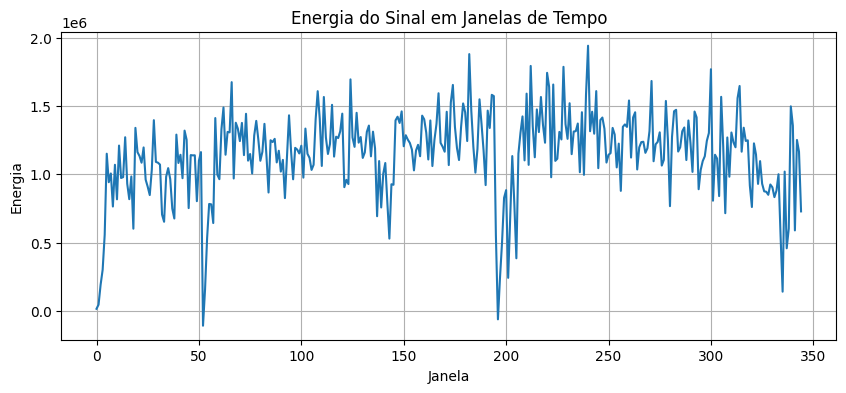

Áudio filtrado salvo como ./filtrado/audio_isolado.wav.
Áudio isolado salvo como ./filtrado/audio_isolado.wav


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

# Função para calcular a energia do sinal em janelas de tempo
def calculate_energy(audio_data, window_size):
    energy = np.array([np.sum(audio_data[i:i+window_size]**2) for i in range(0, len(audio_data), window_size)])
    return energy

# Função para identificar os picos de energia
def detect_peaks(energy, threshold):
    peak_indices = np.where(energy > threshold)[0]
    return peak_indices

# Função para isolar a faixa de tempo com os picos de energia
def isolate_peak_audio(audio_data, sample_rate, peak_indices, window_size):
    start_sample = peak_indices[0] * window_size
    end_sample = (peak_indices[-1] + 1) * window_size
    isolated_audio = audio_data[start_sample:end_sample]
    return isolated_audio

# Função para processar o áudio e isolar a faixa com o estalo
def process_audio_with_energy_detection(filename, output_filename, window_size, threshold):
    # Carregar o áudio filtrado
    sample_rate, audio_data = load_audio(filename)

    # Se o áudio for estéreo, converte para mono
    if len(audio_data.shape) > 1:
        audio_data = np.mean(audio_data, axis=1)

    # Calcular a energia do sinal
    energy = calculate_energy(audio_data, window_size)
    
    # Plotar a energia do sinal
    plt.figure(figsize=(10, 4))
    plt.plot(energy)
    plt.title("Energia do Sinal em Janelas de Tempo")
    plt.xlabel("Janela")
    plt.ylabel("Energia")
    plt.grid()
    plt.show()

    # Detectar picos de energia (estralos)
    peak_indices = detect_peaks(energy, threshold)

    if len(peak_indices) == 0:
        print("Nenhum pico de energia encontrado.")
        return

    # Isolar o áudio correspondente ao pico de energia
    isolated_audio = isolate_peak_audio(audio_data, sample_rate, peak_indices, window_size)

    # Salvar o áudio isolado
    save_filtered_audio(isolated_audio, sample_rate, output_filename)

    print(f"Áudio isolado salvo como {output_filename}")

# Exemplo de uso
FILENAME = "./filtrado/muito_ruido_filtrado.wav"         # Áudio filtrado
OUTPUT_FILENAME = "./filtrado/audio_isolado.wav"   # Nome do áudio isolado
WINDOW_SIZE = 256                      # Tamanho da janela para calcular a energia
THRESHOLD = 0.5                         # Limiar de energia para detectar picos

# Processar o áudio e isolar a faixa com o estalo
process_audio_with_energy_detection(FILENAME, OUTPUT_FILENAME, WINDOW_SIZE, THRESHOLD)

### Nova estratégia para isolar o estralo com base na amplitude

Áudio carregado de ./filtrado/muito_ruido_filtrado.wav.
Áudio filtrado salvo como ./filtrado/audio_isolado.wav.
Áudio isolado salvo como ./filtrado/audio_isolado.wav


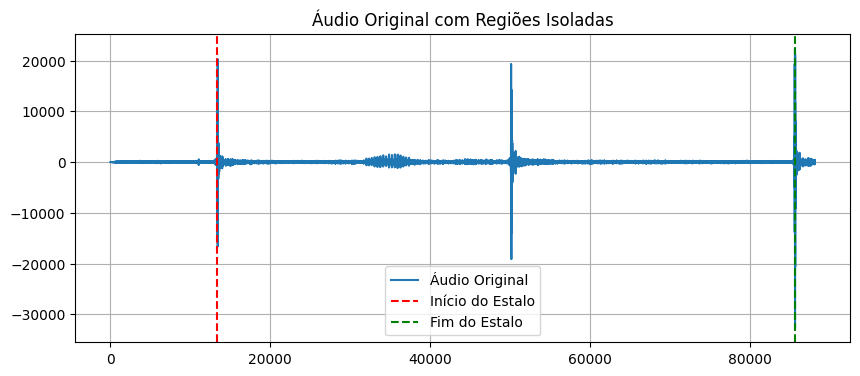

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

# Função para detectar picos com base na amplitude
def detect_peaks_amplitude(audio_data, threshold):
    # Encontrar os índices onde a amplitude excede o limiar
    peak_indices = np.where(np.abs(audio_data) > threshold)[0]
    
    # Se não houver picos acima do limiar, retorna vazio
    if len(peak_indices) == 0:
        return None
    
    # Encontrar o início e o fim da sequência de picos (contínuos)
    start_index = peak_indices[0]
    end_index = peak_indices[-1]
    
    return start_index, end_index

# Função para isolar o áudio entre os picos detectados
def isolate_audio_peaks(audio_data, start_index, end_index):
    isolated_audio = audio_data[start_index:end_index]
    return isolated_audio

# Função para processar o áudio e isolar a faixa com base nos picos de amplitude
def process_audio_by_amplitude(filename, output_filename, threshold):
    # Carregar o áudio filtrado
    sample_rate, audio_data = load_audio(filename)

    # Se o áudio for estéreo, converte para mono
    if len(audio_data.shape) > 1:
        audio_data = np.mean(audio_data, axis=1)

    # Detectar picos com base na amplitude
    peak_indices = detect_peaks_amplitude(audio_data, threshold)

    if peak_indices is None:
        print("Nenhum pico significativo encontrado.")
        return

    # Isolar o áudio entre os picos detectados
    start_index, end_index = peak_indices
    isolated_audio = isolate_audio_peaks(audio_data, start_index, end_index)

    # Salvar o áudio isolado
    save_filtered_audio(isolated_audio, sample_rate, output_filename)

    print(f"Áudio isolado salvo como {output_filename}")

    # Plotar o áudio original e o isolado
    plt.figure(figsize=(10, 4))
    plt.plot(audio_data, label="Áudio Original")
    plt.axvline(start_index, color='r', linestyle='--', label='Início do Estalo')
    plt.axvline(end_index, color='g', linestyle='--', label='Fim do Estalo')
    plt.title("Áudio Original com Regiões Isoladas")
    plt.legend()
    plt.grid()
    plt.show()

# Exemplo de uso
FILENAME = "./filtrado/muito_ruido_filtrado.wav"         # Áudio filtrado
OUTPUT_FILENAME = "./filtrado/audio_isolado.wav"   # Nome do áudio isolado
THRESHOLD = 10000                         # Limiar de amplitude para detectar picos (ajuste conforme necessário)

# Processar o áudio com base nos picos de amplitude
process_audio_by_amplitude(FILENAME, OUTPUT_FILENAME, THRESHOLD)